In [1]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 1D problem such as the (time-independent) Burgers equation discussed in Section 5.1 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)


In [114]:
################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(101, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 100)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        #x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        #x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(-6, 0, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [115]:
################################################################
#  configurations
################################################################
ntrain = 1400
ntest = 100

#sub = 2**3 #subsampling rate
#h = 2**13 // sub #total grid size divided by the subsampling rate
s = 207

batch_size = 25
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 32
width = 72

Tin = 100
T = 100
step = 100

In [752]:
################################################################
# read data
################################################################
x_data = torch.tensor(np.load('data/input_long.npy', allow_pickle=True))[:535,:]
y_data = torch.tensor(np.load('data/u_results_long.npy', allow_pickle=True))[:535,:]


x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

#train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [116]:
x_train = X_Data_PD[:ntrain,:]
y_train = Y_Data_PD[:ntrain,:]
x_test = X_Data_PD[-ntest:,:]
y_test = Y_Data_PD[-ntest:,:]

In [47]:
x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,1)

In [236]:
x_train = x_train[:,:,-201:-1]
y_train = y_train[:,:,0:200]
x_test = x_test[:,:,-201:-1]
y_test = y_test[:,:,0:200]

In [117]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [118]:
# model
model = FNO1d(modes, width).cuda()
print(count_params(model))

1377716


In [119]:
################################################################
# training and evaluation
################################################################
#optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2_full = 0
    train_l2 = 0
    j=1
    for xx, yy in train_loader:
        loss = 0
        xx, yy = xx.cuda(), yy.cuda()
        
        for t in range(0,T,step):
            #print('it enters')
            y = yy[..., t:t+step]
            out = model(xx)
            loss += myloss(out.reshape(batch_size, -1), y.reshape(batch_size, -1))
            #print('it reaches')
            
            if t == 0:
                pred = out
            else:
                pred = torch.cat((pred, out), -1)
                
            xx = torch.cat((xx[..., step:],out),dim=-1)

        optimizer.zero_grad()
        #mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        #l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        loss.backward() # use the l2 relative loss
        optimizer.step()
                           
                           
        #train_mse += mse.item()
        train_l2 += loss.item()
        l2_full = myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1))
        train_l2_full += l2_full.item()

    scheduler.step()
    model.eval()
    test_l2 = 0
    test_l2_full = 0
    j=1
    with torch.no_grad():
        for xx, yy in test_loader:
            loss = 0
            xx, yy = xx.cuda(), yy.cuda()
        
            for t in range(0,T,step):
                #print('test')
                y = yy[..., t:t+step]
                out = model(xx)
                loss += myloss(out.reshape(batch_size, -1), y.reshape(batch_size, -1))
            
                if t == 0:
                    pred = out
                else:
                    pred = torch.cat((pred, out), -1)
                
                xx = torch.cat((xx[..., step:],out),dim=-1)
                           
            #test_mse += mse.item()
            test_l2 += loss.item()
            test_l2_full += myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1)).item()
                               
    t2 = default_timer()
    print(ep, t2-t1, train_l2_full, test_l2_full)


#pred = torch.zeros(y_test.shape)
#index = 0
#test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
#with torch.no_grad():
#    for x, y in test_loader:
#        test_l2 = 0
#        x, y = x.cuda(), y.cuda()

#        out = model(x).view(-1)
#        pred[index] = out

#        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
#        print(index, test_l2)
#        index = index + 1

#scipy.io.savemat('pred/burger_test.mat', mdict={'pred': pred.cpu().numpy()})


0 0.7686450723558664 333.84738302230835 8.77506685256958
1 0.7745139095932245 84.6765763759613 4.079716324806213
2 0.7095803897827864 55.50318771600723 4.0990418791770935
3 0.7115443404763937 53.09459429979324 3.8349879384040833
4 0.7688879892230034 52.34852999448776 3.2540717720985413
5 0.7484937738627195 51.63454973697662 5.359100818634033
6 0.7208764180541039 58.538324892520905 3.2560391426086426
7 0.7058537099510431 47.94712573289871 4.807206034660339
8 0.7060408182442188 42.74179822206497 2.46793931722641
9 0.7026403024792671 35.71414315700531 2.5357691049575806
10 0.708471255376935 33.78962188959122 3.1152432560920715
11 0.7030387334525585 36.05524426698685 2.456972658634186
12 0.7038978133350611 31.589921295642853 2.387039005756378
13 0.7040927093476057 32.526907205581665 2.3062708973884583
14 0.7301979400217533 30.72159942984581 2.3175310492515564
15 0.7086025383323431 31.438016951084137 1.833860993385315
16 0.7177257146686316 36.77157485485077 2.654007077217102
17 0.7117143217

138 0.6983019690960646 2.5598106421530247 0.18059078976511955
139 0.7150631304830313 2.348653845489025 0.15049389004707336
140 0.7017244771122932 3.996228411793709 0.3350279852747917
141 0.7098456081002951 4.2879259288311005 0.2643069848418236
142 0.6994366552680731 3.3489267453551292 0.2170148566365242
143 0.7036642394959927 2.680061139166355 0.15614308044314384
144 0.7028493080288172 2.337492825463414 0.2101411186158657
145 0.7026795744895935 2.4539857506752014 0.16446733102202415
146 0.6961329318583012 2.2727499287575483 0.1575465090572834
147 0.6947350725531578 2.286924408748746 0.17646672576665878
148 0.6970721874386072 2.2863177210092545 0.19116108492016792
149 0.6973080635070801 2.4167555943131447 0.16026419773697853
150 0.6946506090462208 1.588949579745531 0.09847607463598251
151 0.6955397538840771 1.4991373624652624 0.10504113510251045
152 0.6953698396682739 1.535417353734374 0.0973751749843359
153 0.7025709915906191 1.4249582439661026 0.09882373549044132
154 0.694869071245193

272 0.7203146461397409 0.9067179672420025 0.06601855996996164
273 0.7241682223975658 0.9203627407550812 0.06644590012729168
274 0.7260630279779434 0.9095740560442209 0.0654574166983366
275 0.7346334178000689 0.9492484284564853 0.06905296631157398
276 0.7260669879615307 0.9186116997152567 0.06644473597407341
277 0.7212823759764433 0.9192912643775344 0.07039456441998482
278 0.7189170476049185 0.9408549461513758 0.0653457548469305
279 0.7184317968785763 0.9191794851794839 0.06550238840281963
280 0.7204793710261583 0.93318235501647 0.06983285211026669
281 0.7249975465238094 0.936410566791892 0.06803243793547153
282 0.7243219222873449 0.9298268863931298 0.06337166856974363
283 0.7240081261843443 0.909634305164218 0.06854185648262501
284 0.7259642109274864 0.9386415621265769 0.06309518218040466
285 0.7190521322190762 0.9244714491069317 0.06239640060812235
286 0.7329317107796669 0.9520101258531213 0.07087445259094238
287 0.7261585723608732 0.9240341726690531 0.06597146950662136
288 0.71987892

405 0.7664295919239521 0.7412835247814655 0.05388046521693468
406 0.7332766596227884 0.7437296593561769 0.054412282072007656
407 0.7578492052853107 0.7492832709103823 0.05494369566440582
408 0.7379946243017912 0.7478496041148901 0.05445109028369188
409 0.735190138220787 0.7426247112452984 0.057212709449231625
410 0.7488704808056355 0.7507085036486387 0.054608394391834736
411 0.7366410996764898 0.7480779606848955 0.05441966187208891
412 0.7365022823214531 0.7405514251440763 0.05445258505642414
413 0.7345514595508575 0.7415888030081987 0.05427348241209984
414 0.7461879700422287 0.7411502487957478 0.05397417023777962
415 0.7390740290284157 0.7406177278608084 0.05427474807947874
416 0.7597572561353445 0.7431951258331537 0.05418544542044401
417 0.7379007451236248 0.7418142929673195 0.05405722092837095
418 0.7638915311545134 0.7497689295560122 0.054110681638121605
419 0.7344852797687054 0.7463026652112603 0.054012950509786606
420 0.7531104013323784 0.7374345120042562 0.05400738399475813
421 

In [120]:
y_test.shape

torch.Size([100, 207, 100])

In [121]:
pred.shape

torch.Size([25, 207, 100])

In [22]:
x_train.shape

torch.Size([4000, 207, 50])

In [23]:
torch.save(model,'KFR_FNO_somewhatgeneral4.7to4.9_random50bunch')

# Iteration 

In [129]:
xx = torch.tensor(a.tolist()['U_full'][index[1][0][0]][-101:-1,:].T).float().reshape(1,207,100).cuda()
#xx = (U45[-11:-1,:].T).float().reshape(1,207,10).cuda()
for t in range(0,500,1):
    #print('it enters')
    #y = yy[..., t:t+step]
    out = model(xx)
    #loss += myloss(out.reshape(batch_size, -1), y.reshape(batch_size, -1))
    #print('it reaches')
    if t == 0:
        pred_2 = out
    else:
        pred_2 = torch.cat((pred_2, out), -1)

    xx = torch.cat((xx[..., step:],out),dim=-1)

In [95]:
time = []
#trajectory = y_test[-1,:].cpu().numpy()
xx = torch.tensor(a.tolist()['U_full'][175][-1,:].T).float().reshape(1,207,1).cuda()
start_timer = default_timer()
w = model(xx)
time.append(w.cpu().detach().numpy())
for i in range(0,5000):
    with torch.no_grad():
        w = model(w)
    time.append(w.cpu().detach().numpy())
end_timer = default_timer()
print("Time for Evaluation: ", end_timer - start_timer)

    
timenp = np.array(time)

timenp = timenp[:,-1,:,-1]

Time for Evaluation:  11.218208879232407


In [61]:
xx.shape

torch.Size([207])

# Alpha 4.702 : starting from t=(250-200*dt)

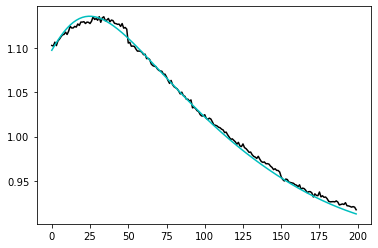

In [242]:
plt.plot(pred[-2,-1,:].cpu().numpy(), 'k')

plt.plot(y_test[-2,-1,:], 'c')

plt.show()

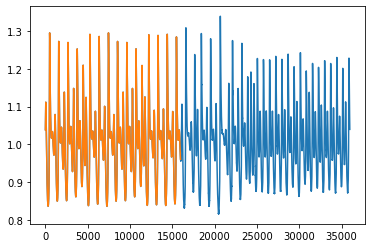

In [685]:
plt.plot(np.append(U5169[5284:,-1],pred_2[-1,-1,:].detach().cpu().numpy()))


plt.plot(U5169[5284:,-1])
#plt.plot(pred_2[-1,-1,:].detach().cpu().numpy())
#plt.plot(a.tolist()['U_full'][0][-801:,-1])

#plt.xlim([17500,18000])

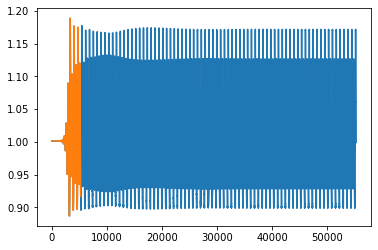

In [130]:
plt.plot(np.append(a.tolist()['U_full'][index[1][0][0]][:,-1],pred_2[-1,-1,:].detach().cpu().numpy()))

plt.plot(a.tolist()['U_full'][index[1][0][0]][:,-1])

#plt.plot(timenp[:,-1])

In [1]:
plt.plot(np.append(a.tolist()['U_full'][100][::20,-1],timenp[:,-1]))

plt.plot(a.tolist()['U_full'][100][::20,-1])

#plt.plot(timenp[:,-1])

NameError: name 'plt' is not defined

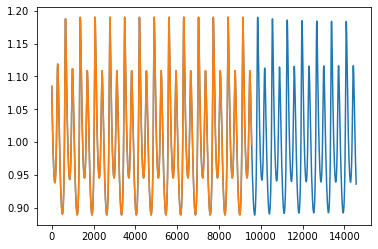

In [849]:
plt.plot(np.append(U485[5200:,-1],pred_2[-1,-1,:].detach().cpu().numpy()))

plt.plot(U485[5200:,-1])

#plt.plot(pred_2[-1,-1,:].detach().cpu().numpy())

#plt.xlim([17500,18000])

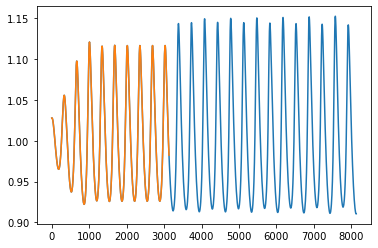

In [853]:
plt.plot(np.append(U45[4200:,-1],pred_2[-1,-1,:].detach().cpu().numpy()))

plt.plot(U45[4200:,-1])

#plt.plot(pred_2[-1,-1,:].detach().cpu().numpy())

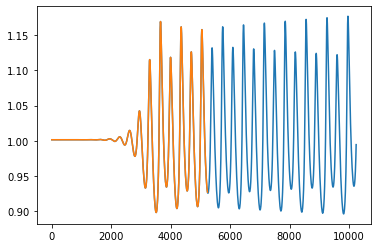

In [862]:
plt.plot(np.append(a.tolist()['U_full'][index[75][0][0]][:,-1],pred_2[-1,-1,:].detach().cpu().numpy()))

plt.plot(a.tolist()['U_full'][index[75][0][0]][:,-1])

#plt.plot(pred_2[-1,-1,:].detach().cpu().numpy())

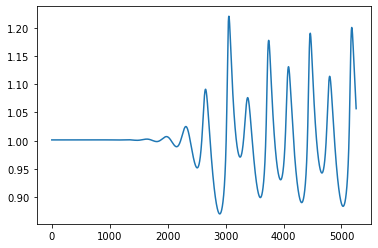

In [791]:
plt.plot(a.tolist()['U_full'][70][:,-1])

In [549]:
U5169 = torch.tensor(np.load('data/u_original5169.npy', allow_pickle=True))

In [613]:
U45 = torch.tensor(np.load('data/u_original45.npy', allow_pickle=True))

In [5]:
a = np.load('data/KFR_data.npy', allow_pickle=True)

# Generating an optimistic training data set

In [6]:
U = a.tolist()['U_full']

In [111]:
from numpy import random #Generate data set with different alphas (4-5.5) and for each alpha have different random 
                         #trajectories of 200 (dts) length
                         #Generate data set with not all alphas from 4-5.5 but just with PD like 4.6-4.9


X_Data_PD = torch.zeros([1500,207,100])
Y_Data_PD = torch.zeros([1500,207,100])
count = 0
for i in range(0,1500):
    #print('i', i)
    start = int(random.uniform(-2000,-401))
    X_Data_PD[count,:,:] = ((torch.from_numpy(U[index[1][0][0]].T)))[:,start:start+100]
    Y_Data_PD[count,:,:] = ((torch.from_numpy(U[index[1][0][0]].T)))[:,start+100:start+200]
    count += 1

In [112]:
Alphalist = a.tolist()['Alpha']

index = []
for i in Alphalist:
    if i>4.7 and i<4.9:
        index.append(np.where(Alphalist == i))